In [20]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://keras.io/api/preprocessing/image/
# conda install -n assignment_2 ipykernel --update-deps --force-reinstall
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.10.0


In [39]:
# Loading images

batch_size = 32
img_height = 32
img_width = 32

train_val_split = 0.2
val_test_split = 0.5

print("Data distribution:")
print(f"Training: {(1 - train_val_split):.2%}")
print(f"validation: {(train_val_split * (1-val_test_split)):.2%}")
print(f"Test: {(train_val_split * val_test_split):.2%}")

train_ds = tf.keras.utils.image_dataset_from_directory(
  "images",
  validation_split=train_val_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "images",
  validation_split=train_val_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_batches = int(int(val_ds.cardinality()) * val_test_split)
test_ds = val_ds.take(test_batches)
print(f"Test samples: {test_ds.cardinality() * batch_size}")
val_ds = val_ds.skip(test_batches)
print(f"Validation samples: {val_ds.cardinality() * batch_size}")

class_names = train_ds.class_names
print(class_names)


Data distribution:
Training: 80.00%
validation: 10.00%
Test: 10.00%
Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Test samples: 992
Validation samples: 1024
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


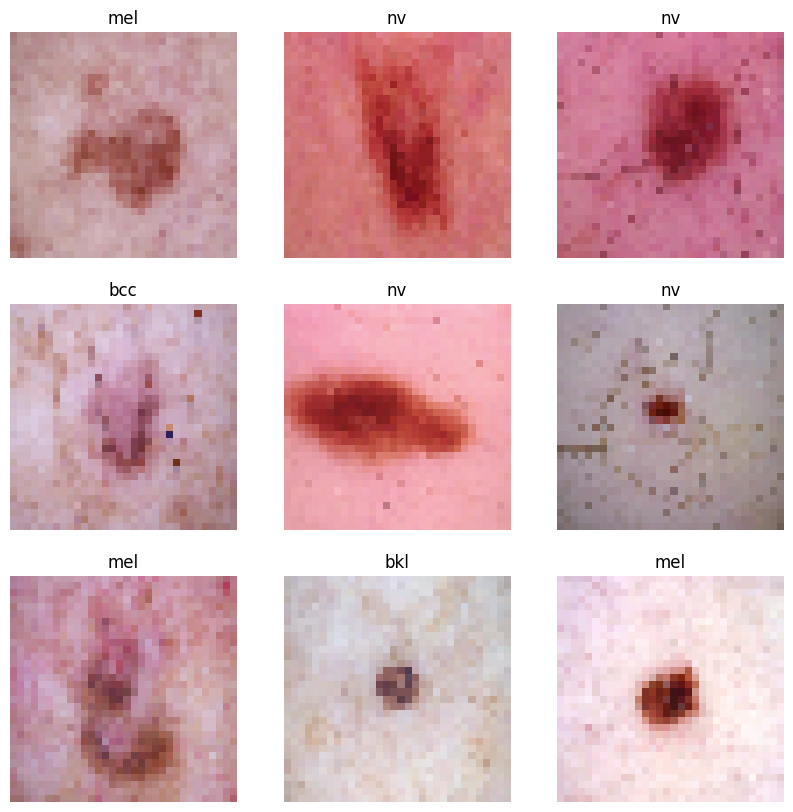

In [5]:
# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [40]:
# AUGMENTATION
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [46]:
# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.20136979 0.83014935


In [42]:
# Training a model
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [50]:
optimizers = [
    'adam',
    'sgd',
    'adadelta',
    'adamax',
    'rmsprop'
]

for optim in optimizers:

    model.compile(
    optimizer=optim,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
    
    print(f"Using {optim} optimizer")
    model.fit(
        normalized_ds,
        validation_data=normalized_val_ds,
        epochs=3
    )

Epoch 1/3
251/251 [==============================] - 25s 94ms/step - loss: 0.8717 - accuracy: 0.6901 - val_loss: 0.8076 - val_accuracy: 0.6963
Epoch 2/3
251/251 [==============================] - 24s 92ms/step - loss: 0.7540 - accuracy: 0.7195 - val_loss: 0.7655 - val_accuracy: 0.7122
Epoch 3/3
251/251 [==============================] - 29s 110ms/step - loss: 0.7308 - accuracy: 0.7250 - val_loss: 0.7711 - val_accuracy: 0.7033
Epoch 1/3
250/251 [============================>.] - ETA: 0s - loss: 0.8282 - accuracy: 0.7001

In [49]:
loss_funcs = [
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    tf.keras.losses.CategoricalHinge(),
    tf.keras.losses.MeanSquaredError()
]

for loss_func in loss_funcs:

    model.compile(
    optimizer='adam',
    loss=loss_func,
    metrics=['accuracy'])
    
    print(f"Using {str(loss_func)} loss function")
    model.fit(
        normalized_ds,
        validation_data=normalized_val_ds,
        epochs=3
    )

Epoch 1/3
251/251 [==============================] - 24s 92ms/step - loss: 0.7848 - accuracy: 0.7059 - val_loss: 0.8010 - val_accuracy: 0.6963
Epoch 2/3
251/251 [==============================] - 23s 91ms/step - loss: 0.7579 - accuracy: 0.7182 - val_loss: 0.8036 - val_accuracy: 0.6924
Epoch 3/3
251/251 [==============================] - 24s 93ms/step - loss: 0.7482 - accuracy: 0.7230 - val_loss: 0.8029 - val_accuracy: 0.6963
Epoch 1/3
251/251 [==============================] - 23s 87ms/step - loss: 0.4645 - accuracy: 0.1038 - val_loss: 0.0376 - val_accuracy: 0.1563
Epoch 2/3
251/251 [==============================] - 23s 91ms/step - loss: 0.0424 - accuracy: 0.1191 - val_loss: 0.0404 - val_accuracy: 0.0772
Epoch 3/3
251/251 [==============================] - 23s 88ms/step - loss: 0.0407 - accuracy: 0.0937 - val_loss: 0.0414 - val_accuracy: 0.0356
Epoch 1/3
251/251 [==============================] - 23s 88ms/step - loss: 2.4487 - accuracy: 0.1883 - val_loss: 1.6306 - val_accuracy: 0.3056

In [44]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [47]:
model.fit(
  normalized_ds,
  validation_data=normalized_val_ds,
  epochs=3
)

Epoch 1/3
251/251 [==============================] - 23s 90ms/step - loss: 0.8614 - accuracy: 0.6850 - val_loss: 0.8858 - val_accuracy: 0.6686
Epoch 2/3
251/251 [==============================] - 23s 91ms/step - loss: 0.8293 - accuracy: 0.6941 - val_loss: 0.8543 - val_accuracy: 0.6845
Epoch 3/3
251/251 [==============================] - 22s 87ms/step - loss: 0.8077 - accuracy: 0.7003 - val_loss: 0.8109 - val_accuracy: 0.6914
